In [1]:
import geopandas as gpd
import pandas as pd
import datetime
from dateutil import tz
import stride
import folium

In [2]:
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [3]:
def localize_dates(data, dt_columns = []):
    data = data.copy()
    
    for c in dt_columns:
        data[c] = pd.to_datetime(data[c]).dt.tz_convert('Israel')
    
    return data

In [4]:
pd.DataFrame(stride.get('/gtfs_routes/list', {'route_short_name':617,
                                                            'agency_name': 'תנופה',
                                                            'route_long_name_contains': 'ירושלים',
                                              'date_from': '2022-12-12',
                                              'date_to':  '2022-12-12'}))

,id,date,line_ref,operator_ref,route_short_name,route_long_name,route_mkt,route_direction,route_alternative,agency_name,route_type
0,1868612,2022-12-12,32541,34,617,תחנה תפעולית חניון 4/9-ירושלים<->אליהו הנביא/הרב שלמה זלמן אויערבך-בית שמש-10,11617,1,0,תנופה,3
1,1868613,2022-12-12,32542,34,617,אליהו הנביא/אביב-בית שמש<->צומת רמות/גולדה-ירושלים-20,11617,2,0,תנופה,3
2,1868614,2022-12-12,32543,34,617,שדרות הרב הרצוג/שדרות נהר הירדן-בית שמש<->צומת רמות/גולדה-ירושלים-21,11617,2,1,תנופה,3


In [5]:
siri_locations_617_before = pd.DataFrame(stride.get('/siri_vehicle_locations/list', {
    'siri_routes__line_ref': '32541',
    'limit': -1,
    'siri_rides__schedualed_start_time_from': datetime.datetime(2022,12, 4, tzinfo=tz.gettz('Israel')),
    'siri_rides__schedualed_start_time_to': datetime.datetime(2022,12, 8, tzinfo=tz.gettz('Israel'))+datetime.timedelta(days=1),
    'order_by': 'recorded_at_time desc',
    'lon__greater_or_equal': 35.11072,
    'lon__lower_or_equal': 35.19520,
    'lat__greater_or_equal': 31.76620,
    'lat__lower_or_equal': 31.81334
}))

siri_locations_617_before.shape

(2453, 35)

In [6]:
dt_columns = ['recorded_at_time','siri_ride__scheduled_start_time']

siri_locations_617_before = localize_dates(siri_locations_617_before, dt_columns)

In [7]:
locations_617_before = siri_locations_617_before[['recorded_at_time','siri_ride__scheduled_start_time',
                                   'lon','lat','siri_ride__vehicle_ref', 'siri_ride__id', 'distance_from_journey_start', 'velocity']]

## Visualizing the data to see if nothing looks wrong

#### Let's look at the last siri call of each ride

In [8]:
last_recs_before = locations_617_before.groupby('siri_ride__id').first()

m = folium.Map(location=[31.79,35.14], zoom_start=14, tiles='OpenStreetMap')
for i in last_recs_before.index:
    m.add_child(
        folium.Marker(
            location=[last_recs_before.lat[i], last_recs_before.lon[i]],
            popup=i
        )
    )

m

##### All the data points are after the Harel tunnel, except for rides #25615444, #25743313, #25845675

#### The same for the first siri call:

In [9]:
first_recs_before = locations_617_before.groupby('siri_ride__id').last()

m = folium.Map(location=[31.80,35.19], zoom_start=15, tiles='OpenStreetMap')
for i in first_recs_before.index:
    m.add_child(
        folium.Marker(
            location=[first_recs_before.lat[i], first_recs_before.lon[i]],
            popup=i
        )
    )

m

Again, ride #25845675 singles out

#### Now let's create a single DF with the first and last calls for each ride

In [10]:
first_last_before = first_recs_before.join(last_recs_before, rsuffix='_last')
first_last_before.shape

(299, 14)

##### Removing the problematic rides:

In [11]:
first_last_before = first_last_before.drop([25615444, 25743313, 25845675])
first_last_before.shape

(296, 14)

##### Creating measures:

In [12]:
first_last_before['distance_traveled'] = first_last_before['distance_from_journey_start_last'] - first_last_before['distance_from_journey_start']
first_last_before['distance_traveled'].describe()

count     296.000000
mean     7801.692568
std       528.191565
min      6351.000000
25%      7442.750000
50%      7782.000000
75%      8186.000000
max      8945.000000
Name: distance_traveled, dtype: float64

In [13]:
first_last_before['time_traveled'] = first_last_before['recorded_at_time_last'] - first_last_before['recorded_at_time']
first_last_before['time_traveled'].describe()

count                          296
mean     0 days 00:07:14.908783783
std      0 days 00:03:05.456747547
min                0 days 00:04:00
25%                0 days 00:05:04
50%                0 days 00:05:59
75%         0 days 00:08:01.250000
max                0 days 00:17:04
Name: time_traveled, dtype: object

In [14]:
first_last_before['mins_traveled'] = first_last_before['time_traveled'].dt.total_seconds()/60
first_last_before['ride_start_time'] = first_last_before['siri_ride__scheduled_start_time'].dt.hour + first_last_before['siri_ride__scheduled_start_time'].dt.minute/60

<AxesSubplot: xlabel='ride_start_time', ylabel='mins_traveled'>

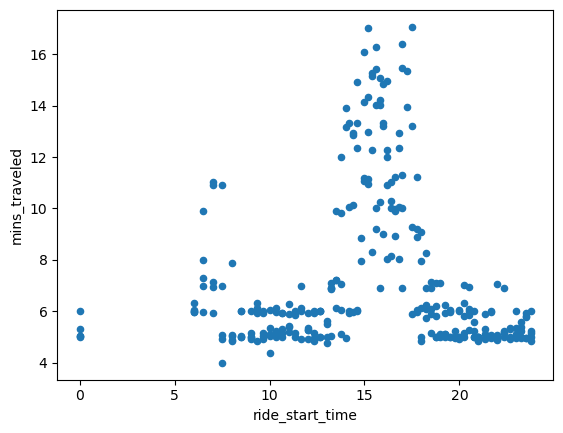

In [15]:
first_last_before.plot.scatter('ride_start_time', 'mins_traveled')

### Now' let's compute the average travel time based on the departure time of the bus

<AxesSubplot: xlabel='ride_start_time'>

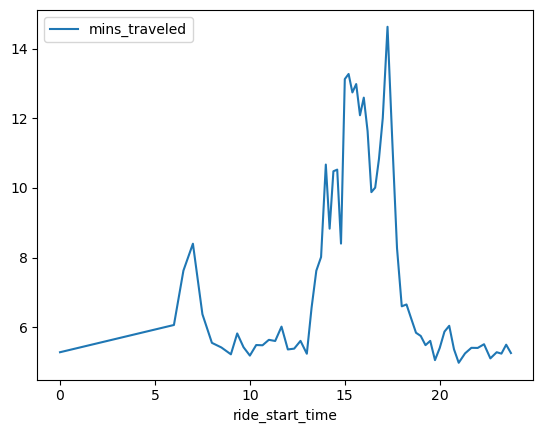

In [16]:
avgs_before = first_last_before.groupby('ride_start_time').mean(numeric_only=False).reset_index()
avgs_before.plot.line('ride_start_time', 'mins_traveled')

In [17]:
#avgs.to_excel('before_ramp.xlsx')

## Now, the same for the week after the ramp was opened

In [18]:
siri_locations_617_after = pd.DataFrame(stride.get('/siri_vehicle_locations/list', {
    'siri_routes__line_ref': '32541',
    'limit': -1,
    'siri_rides__schedualed_start_time_from': datetime.datetime(2022,12, 18, tzinfo=tz.gettz('Israel')),
    'siri_rides__schedualed_start_time_to': datetime.datetime(2022,12, 22, tzinfo=tz.gettz('Israel'))+datetime.timedelta(days=1),
    'order_by': 'recorded_at_time desc',
    'lon__greater_or_equal': 35.11072,
    'lon__lower_or_equal': 35.19520,
    'lat__greater_or_equal': 31.76620,
    'lat__lower_or_equal': 31.81334
}))

In [19]:
dt_columns = ['recorded_at_time','siri_ride__scheduled_start_time']
siri_locations_617_after = localize_dates(siri_locations_617_after, dt_columns)

In [20]:
locations_617_after = siri_locations_617_after[['recorded_at_time','siri_ride__scheduled_start_time',
                                   'lon','lat','siri_ride__vehicle_ref', 'siri_ride__id', 'distance_from_journey_start', 'velocity']]

In [21]:
last_recs_after = locations_617_after.groupby('siri_ride__id').first()

m = folium.Map(location=[31.79,35.15], zoom_start=14, tiles='OpenStreetMap')
for i in last_recs_after.index:
    m.add_child(
        folium.Marker(
            location=[last_recs_after.lat[i], last_recs_after.lon[i]],
            popup=i
        )
    )

m

##### All the data points are after the Harel tunnel, except for rides #26585497, #26792835, #26999271, #26895034

#### The same for the first siri call:

In [22]:
first_recs_after = locations_617_after.groupby('siri_ride__id').last()

m = folium.Map(location=[31.80,35.18], zoom_start=14, tiles='OpenStreetMap')
for i in first_recs_after.index:
    m.add_child(
        folium.Marker(
            location=[first_recs_after.lat[i], first_recs_after.lon[i]],
            popup=i
        )
    )

m

Again, ride #26585497 is wrong, and also rides #26694290, #27017279

#### Combining first and last calls for each ride

In [23]:
first_last_after = first_recs_after.join(last_recs_after, rsuffix='_last')
first_last_after.shape

(310, 14)

##### Removing the problematic rides:

In [24]:
first_last_after = first_last_after.drop([26585497, 26792835, 26999271 ,26694290, 27017279, 26895034])
first_last_after.shape

(304, 14)

##### Creating measures:

In [25]:
first_last_after['distance_traveled'] = first_last_after['distance_from_journey_start_last'] - first_last_after['distance_from_journey_start']
first_last_after['distance_traveled'].describe()

count     304.000000
mean     7838.601974
std       553.590223
min      5828.000000
25%      7470.500000
50%      7883.500000
75%      8268.000000
max      8932.000000
Name: distance_traveled, dtype: float64

In [26]:
first_last_after['time_traveled'] = first_last_after['recorded_at_time_last'] - first_last_after['recorded_at_time']
first_last_after['time_traveled'].describe()

count                          304
mean     0 days 00:07:56.726973684
std      0 days 00:04:38.346641085
min                0 days 00:03:52
25%                0 days 00:05:06
50%                0 days 00:06:00
75%         0 days 00:08:29.250000
max                0 days 00:34:12
Name: time_traveled, dtype: object

In [27]:
first_last_after['mins_traveled'] = first_last_after['time_traveled'].dt.total_seconds()/60
first_last_after['ride_start_time'] = first_last_after['siri_ride__scheduled_start_time'].dt.hour + first_last_after['siri_ride__scheduled_start_time'].dt.minute/60

<AxesSubplot: xlabel='ride_start_time', ylabel='mins_traveled'>

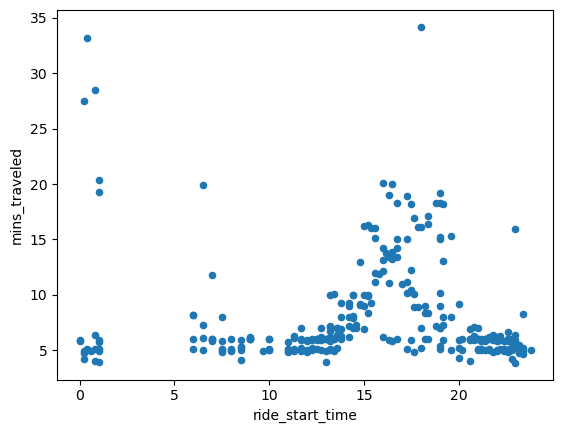

In [28]:
first_last_after.plot.scatter('ride_start_time', 'mins_traveled')

#### More rides at night (probably due to Hanukkah). Some of it with very high travel times, but we don't really care about it (maybe road works?)

### Now' let's compute the average travel time based on the departure time of the bus

<AxesSubplot: xlabel='ride_start_time'>

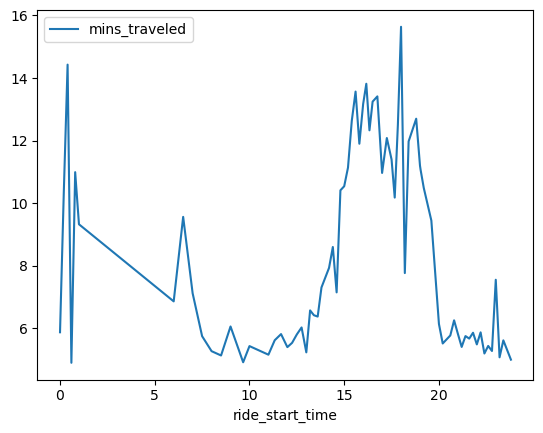

In [29]:
avgs_after = first_last_after.groupby('ride_start_time').mean(numeric_only=False).reset_index()
avgs_after.plot.line('ride_start_time', 'mins_traveled')

# Finally let's compare the two weeks

In [30]:
combined = avgs_after[['ride_start_time', 'mins_traveled']].set_index('ride_start_time').join(avgs_before[['ride_start_time', 'mins_traveled']].set_index('ride_start_time'), rsuffix='_before')

<AxesSubplot: xlabel='ride_start_time'>

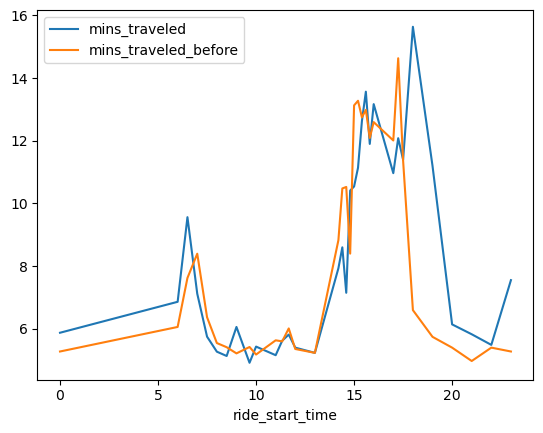

In [31]:
combined.dropna().plot.line()

# Seems like the openning of the ramp didn't have much impact on Road 1